In [2]:
import theano
import theano.tensor as T
import theano.tensor.nnet as nnet
import numpy as np
import time

import cv2 
import numpy as np
import math
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import signal
import time
from math import sqrt
from skimage import transform
import skimage 

In [3]:
# functions 

circle = lambda r: np.array([[1 if sqrt((i-r)**2 + (j-r)**2) <= r else 0 for j in range(0, 2*r+1)] for i in range(0, 2*r+1)])

def absolute(x, y):
    return(math.sqrt(x**2 + y**2))
vect_absolute = np.vectorize(absolute)

def power(input):
    return input**2
vect_power = np.vectorize(power)

def normalizeNPA(img):
    w, h = img.shape
    denominator = np.ones((w, h)) * np.amax(img)
    return img/denominator

def get_rescaled(img, percent):
    width, height = img.shape
    resized = skimage.transform.resize(img, output_shape=[int(width * percent), 
                int(height * percent)], order=1, mode='constant', cval=0, clip=True, preserve_range=False)
    return resized

def crop_img(img, radius):
    width, height = img.shape
    return img[radius:width - radius, radius:height - radius]

def cutgreylevels(img, begin_p, end_p):
    maxval = img.max()
    diff_mapp = np.logical_and(maxval * begin_p < img, img < maxval * end_p)
    cut = diff_mapp * img
    output = np.divide(cut - cut.min(), cut.max())
    return output

def calc_dist(histogram, x, y):
    base = histogram[x][y]
    rep_base = np.tile(base,(3, 1))
    extended_base = np.ndarray((3, 3, 10))
    extended_base[:] = rep_base
    dist = (extended_base - histogram[x-1:x+2, y-1:y+2])
    dist = np.power(dist, 2)
    dist = np.sum(dist, axis=2)
    dist = np.sqrt(dist)
    dist = np.sum(np.sum(dist))
    return dist

def get_scale(magnitude_angle, angle):
    # returns the ammount the magnitude should be scaled in 
    # reference to given angle only count positive values     
    output = abs((1 - np.absolute(np.divide(magnitude_angle - angle, math.pi/2))))
    return output

def get_mapp(magnitude_angle, angle):
    # -pi <= angle <= pi 
    # determines if the magnitude_angle is pointing in the same direction as the 
    mapp_angles = np.logical_and(magnitude_angle <= math.pi/2 + angle, magnitude_angle >= -math.pi/2 + angle)
    return mapp_angles

def normalizeStd1Mean0(image):
    image = image - np.mean(image)
    return image/np.std(image)

def histEq(image, number_bins=256):

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, normed=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape), cdf

def inverse(img):
    return np.abs(img - 1)

def threshold(img):
    thresh = np.mean(img)
    img[img > thresh] = 1
    img[img <= thresh] = 0
    return img

# M1 
# The variance of the greylevel histogram over a circular neighbourhood
# of radius 3 (total area N = 29 pixels) at each pixel is used as a measure of how much local information there is:

def calc_M1(img):
    width, height = img.shape
    bins = 10
    histogram = np.ndarray((width, height, bins))
    hist_variance = np.zeros((width, height))
    radius = 3
    kernel = circle(radius)
    denominator = kernel.sum()
    img_force_int = img.astype('float')
    for x in range(radius, width-radius):
        for y in range(radius, height-radius):
            crop = img_force_int[x - radius:x + radius + 1, y - radius:y + radius + 1]
            croped_crop = crop[kernel == 1]
            hist, trash = np.histogram(np.hstack(croped_crop),bins)
            histogram[x][y] = hist
            var = np.nanvar(histogram[x][y])
            hist_variance[x][y] = var
    
#     histogram_croped = histogram[radius:width - radius, radius:height - radius]
#     hist_variance_croped = hist_variance[radius:width - radius, radius:height - radius]    
    M1 = hist_variance
    return M1, histogram

# M2
# Text regions have a high density of edges. This density is measured in a circular neighbourhood of 
# radius 6 centred at each pixel by summing all edge magnitudes located with a Sobel filter:

def calc_M2(img):
    Gx_kernel = np.matrix([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gy_kernel = np.matrix([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    Gx = signal.convolve2d(img, Gx_kernel, 'same')
    Gy = signal.convolve2d(img, Gy_kernel, 'same')
    G = vect_absolute(Gx, Gy)
    G = G.astype(np.uint8)
    # sum all edge magnitudes 
    kernel = circle(6)
    M2 = signal.convolve2d(G, kernel, 'same')
    
    return M2

# M3
# the ratio of text to non-text intensity greylevels should not vary greatly as we pass over a text region.
# hypothesise that there will be only a small change in local greylevel histograms across a text region.

def calc_M3(histogramFromM1):
    width, height, bins = histogramFromM1.shape
    M3 = np.zeros((width, height))
    for x in range(1, width-2):
        for y in range(1, height-2):
            dist = calc_dist(histogramFromM1, x, y)
            M3[x][y] = dist

    return M3

# M4
# In high resolution images one expects to find a high number of edges in a text region, and 
# the angles of the edges to be well distributed due to the presence of curves on many characters. 
# However, this will not be the case at low resolution, where individual characters merge and edges follow
# the tops and bottoms of text lines.

# Different take on the filter, only use angle not magnitude. 

def calc_M4(img):
    
    width, height = img.shape
    angle = 0
    radius = 6
    bins = 8
    kernel = circle(radius)
    
    # calculate magnitude vector
    Gx_kernel = np.matrix([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gy_kernel = np.matrix([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    Gx = signal.convolve2d(img, Gx_kernel, 'same')
    Gy = signal.convolve2d(img, Gy_kernel, 'same')
    Gvector = np.ndarray([2, width, height])
    Gvector[0, ...] = Gx
    Gvector[1, ...] = Gy
    magnitude = vect_absolute(Gx, Gy)
    # calculate angles of magnitude
    magnitude_angle = np.arctan2(Gx, Gy)

    histograms = np.ndarray((width, height, 2, bins))
    M4 = np.ndarray((width, height))
    # print(crop.size)
    for x in range(radius, width - radius):
        for y in range(radius, height - radius):
            crop = magnitude_angle[(x - radius):(x + radius + 1), (y - radius):(y + radius + 1)]
            cropped_with_kernel = crop[kernel == 1]
            cropped_with_kernel = cropped_with_kernel.reshape(cropped_with_kernel.size, 1)
            # mapp instances of 0 < x <= pi to 1 and pi < x <= 2pi to 0           
            mapp = np.logical_and(0 < cropped_with_kernel, cropped_with_kernel <= math.pi)
            # crop_1 is the angles from 0  to  pi
            # crop_2 is the angles from pi to 2pi     
            crop_1 = cropped_with_kernel[mapp == 1]
            crop_2 = cropped_with_kernel[mapp == 0]

            # when the size of either part is zero we create a "zero" histogram,
            # an array of zeros the size of the number of bins(in this case 8)
            if (crop_1.size == 0):
                histogram_1 = np.zeros(8)
                histogram_2, trash = np.histogram(np.hstack(crop_2),bins)
            elif (crop_2.size == 0):
                histogram_1, trash = np.histogram(np.hstack(crop_1),bins)
                histogram_2 = np.zeros(8)
            else: 
                histogram_1, trash = np.histogram(np.hstack(crop_1),bins)            
                histogram_2, trash = np.histogram(np.hstack(crop_2),bins)

            diff = histogram_1 - np.flipud(histogram_2)
            power = vect_power(diff)
            result = math.sqrt(sum(power))
            M4[x, y] = result
            histograms[x, y, 0] = histogram_1
            histograms[x, y, 1] = histogram_2
    
#     histograms_croped = histograms[radius:width - radius, radius:height - radius]
    
    return M4, histograms

# M5
# The first four measures respond in the same way to straight image features as to coarse or curved features. 
# This measure is employed to reject those areas of the image with tight distributions
# of edges corresponding to straight ramps, canals or ridges in the image. 
# It examines how evenly spread the edge magnitudes are over all the directions:

# use histograms calculated in M4
def calc_M5(histogramFromM4):
    bins = 8
    width, height, trash, trash = histogramFromM4.shape
    pi = math.pi
    M5 = np.ndarray((width, height))
    for x in range(0, width):
        for y in range(0, height):
            histogram_1 = histogramFromM4[x, y, 0]
            histogram_2 = histogramFromM4[x, y, 1]
            local_average = (sum(histogram_1) + sum(histogram_2))/(bins*2)
            result = 0
            for theta in range(0, 8):
                # use absolute value
    #             result += abs(local_average - histogram_1[theta])
    #             result += abs(local_average - histogram_2[theta])
                # use power of
                result += (local_average - histogram_1[theta])**2
                result += (local_average - histogram_2[theta])**2
            M5[x, y] = result

    return M5


def sizeofimg(img):
    W, H = img.shape
    print "W " + str(W) + " H " + str(H)

In [4]:
def layer(x, w):
    b = np.array([1], dtype=theano.config.floatX)
    new_x = T.concatenate([x, b])
    m = T.dot(w.T, new_x)
    h = nnet.sigmoid(m)
    return h

def grad_desc(cost, theta):
    alpha = 0.1 #learning rate
    #     T.grad(function, wrt=theta)) 
    #     derive function with respect to theta
    return theta - (alpha * T.grad(cost, wrt=theta))

In [5]:
x = T.dscalar()
fx = T.exp(T.sin(x**2))

f = theano.function(inputs=[x], outputs=[fx])
f(10)

fp = T.grad(fx, wrt=x)
fprime = theano.function([x], fp)
fprime(15)

x = T.dvector()
y = T.dscalar()

In [6]:
theta1 = theano.shared(np.array(np.random.rand(3,3), dtype=theano.config.floatX))
theta2 = theano.shared(np.array(np.random.rand(4,1), dtype=theano.config.floatX))

# theta1.eval()

hidl = layer(x, theta1) #hidden layer
outl = T.sum(layer(hidl, theta2)) #output layer
fc = (outl - y)**2 #cost expression

cost = theano.function(inputs=[x, y], outputs=fc, updates=[
        (theta1, grad_desc(fc, theta1)),
        (theta2, grad_desc(fc, theta2))])

# updates allows us to update our shared variables according to an expression. 
# updates expects a list of 2-tuples:
# updates=[(shared_variable, update_value), ...]
run_forward = theano.function(inputs=[x], outputs=outl)                                         

inputs = np.array([[0,1],[1,0],[1,1],[0,0]]).reshape(4,2) #training data X
exp_y = np.array([1, 1, 0, 0]) #training data Y
cur_cost = 0
for i in range(10000):
    for k in range(len(inputs)):
        cut_cost = cost(inputs[k], exp_y[k])
        if i % 5000 == 0: #only print the cost every 500 epochs/iterations (to save space)
            print 'Cost: %s' % (cut_cost,)
            
            
#Training done! Let's test it out
print(run_forward([0,1]))
print(run_forward([1,1]))
print(run_forward([1,0]))
print(run_forward([0,0]))

Cost: 0.128846893981
Cost: 0.118147088335
Cost: 0.460933831682
Cost: 0.388454107489
Cost: 0.00471997674148
Cost: 0.00258616910315
Cost: 0.00528736707301
Cost: 0.00151538201871
0.960186565902
0.0388485937946
0.976201480934
0.0228625506833


In [7]:
start = time.time()
img = cv2.imread('./img/bok11.png', 0)
kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(img,-1,kernel)
img_rescaled = get_rescaled(dst, 0.2)

M1, histogramFromM1  = calc_M1(img_rescaled)


In [31]:
M1cp = M1
M1norm = normalizeStd1Mean0(M1)
imgRescaledNorm = img_rescaled/np.amax(img_rescaled)

In [32]:
# M1network
x = T.dvector()
y = T.dscalar()

theta1 = theano.shared(np.array(np.random.rand(30, 30), dtype=theano.config.floatX))
theta2 = theano.shared(np.array(np.random.rand(31, 1), dtype=theano.config.floatX))

# hidden layer
hidl = layer(x, theta1)
outl = T.sum(layer(hidl, theta2))

# cost expression
fc = (outl - y)**2 

cost = theano.function(inputs=[x, y], outputs=fc, updates=[
        (theta1, grad_desc(fc, theta1)),
        (theta2, grad_desc(fc, theta2))])

run_forward = theano.function(inputs=[x], outputs=outl)

# train M1 filter

In [39]:
width, height = M1norm.shape
radius = 3
kernel = circle(radius)

crop = M1norm[0:radius * 2 + 1, 0:radius * 2 + 1]
trainingset = crop[kernel == 1].reshape(1, 29)
target = np.array([M1[radius, radius]])
start = time.time()

for col in range(radius, width-radius):
    for row in range(radius, height-radius):
        crop = imgRescaledNorm[col - radius:col + radius + 1, row - radius:row + radius + 1]
        x_set = crop[kernel == 1].reshape(1, 29)
        y_set = np.array([M1norm[col, row]])
        cost(x_set[0], y_set[0])

print str(int(time.time() - start)) + " sec"

18 sec


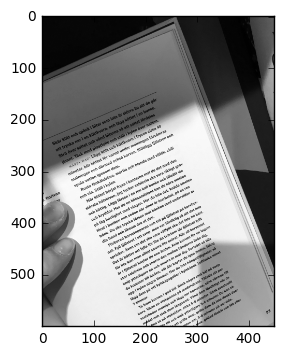

In [40]:
plt.figure(num=None, figsize=(4, 4), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(imgRescaledNorm, 'gray')

In [41]:
# rebuild image with output from filter
newM1 = np.ndarray([width, height])
radius = 3
kernel = circle(radius)
for col in range(radius, width-radius):
    for row in range(radius, height-radius):
        crop = img_rescaled[col - radius:col + radius + 1, row - radius:row + radius + 1]
        x_set = crop[kernel == 1].reshape(1, 29)
        pixel = run_forward(x_set[0])
        newM1[col, row] = pixel



0.950617283951
1.28498990177e-10


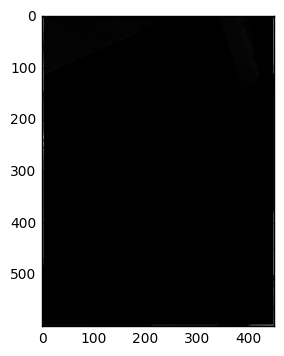

In [43]:
plt.figure(num=None, figsize=(4, 4), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(newM1, 'gray')
print np.amax(newM1)
print np.amin(newM1)

In [47]:
histM1, bins = histEq(newM1)
print histM1.shape


(600, 450)


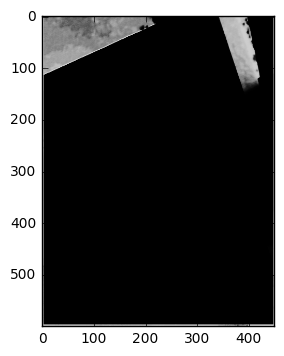

In [48]:
plt.figure(num=None, figsize=(4, 4), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(histM1, 'gray')